# BERTimbau

##### O BERTimbau é uma variante do BERT (Bidirectional Encoder Representations from Transformers), um modelo de linguagem pré-treinado desenvolvido pela Google. O BERT foi projetado para compreender a linguagem natural de maneira bidirecional, ou seja, ele considera o contexto das palavras à esquerda e à direita de uma determinada palavra em uma sentença. O BERTimbau, especificamente, é ajustado para a língua portuguesa e foi treinado em um grande corpus de textos em português.

# Treinando BERTimbau

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

# Carregar os dados
data = pd.read_csv('dados_reviews_tratados.csv')

# Preparar os dados de entrada e saída
X = data['content'].astype(str).tolist() 
y = data['sentiment'].tolist()

# Codificar os rótulos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Carregar o tokenizador e o modelo do bertimbau
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=len(label_encoder.classes_))

# Tokenizar os textos
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)

train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Criar os DataLoaders para treinamento e teste
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewsDataset(train_encodings, y_train)
test_dataset = ReviewsDataset(test_encodings, y_test)

# Configurar os parâmetros de treinamento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Treinar o modelo
trainer.train()

# Avaliar o modelo
results = trainer.evaluate()
print(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_6392/1983592204.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
10,1.913600
20,1.899700
30,1.875300
40,1.789600
50,1.778900
60,1.755400
70,1.581200
80,1.585100
90,1.584300
100,1.501200


/tmp/ipykernel_6392/1983592204.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_6392/1983592204.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.9598256945610046, 'eval_runtime': 60.1054, 'eval_samples_per_second': 10.032, 'eval_steps_per_second': 1.264, 'epoch': 3.0}


# Salvando treinamento

In [8]:
model.save_pretrained('./modelo_bertimbau_emocao')
tokenizer.save_pretrained('./modelo_bertimbau_emocao')

('./modelo_bertimbau_emocao/tokenizer_config.json',
 './modelo_bertimbau_emocao/special_tokens_map.json',
 './modelo_bertimbau_emocao/vocab.txt',
 './modelo_bertimbau_emocao/added_tokens.json')

# Previsão a partir do modelo treinado salvo

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader

# Carregar os dados
data = pd.read_csv('dados_reviews_tratados.csv')

# Preparar os dados de entrada e saída
X = data['content'].astype(str).tolist()
y = data['sentiment'].tolist()

# Codificar as etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir os dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Carregar o tokenizador e o modelo treinado
tokenizer = BertTokenizer.from_pretrained('./modelo_bertimbau_emocao')
model = BertForSequenceClassification.from_pretrained('./modelo_bertimbau_emocao')

# Definir o dataset
class ReviewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

val_dataset = ReviewsDataset(X_val, y_val, tokenizer)

# Obter previsões
def get_predictions(dataset):
    predictions = []
    true_labels = []
    model.eval()
    for batch in DataLoader(dataset, batch_size=8):
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(true_labels)

# Função para prever a emoção de um texto
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {key: value.to(model.device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    pred = torch.argmax(probs, dim=1)
    return label_encoder.inverse_transform(pred.cpu().numpy())[0]

# Obter previsões e etiquetas verdadeiras
y_pred, y_true = get_predictions(val_dataset)


# Classificação e Matriz e Confusão

/home/arthurwsl/classificao_textos/Classificacao_textos/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arthurwsl/classificao_textos/Classificacao_textos/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arthurwsl/classificao_textos/Classificacao_textos/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

Classification Report:
              precision    recall  f1-score   support

       anger       0.72      0.65      0.68       153
     disgust       0.59      0.66      0.62       188
        fear       0.00      0.00      0.00         5
   happiness       0.70      0.70      0.70        64
     neutral       0.31      0.53      0.39        19
     sadness       0.71      0.65      0.68       172
    surprise       0.00      0.00      0.00         2

    accuracy                           0.65       603
   macro avg       0.43      0.46      0.44       603
weighted avg       0.65      0.65      0.65       603



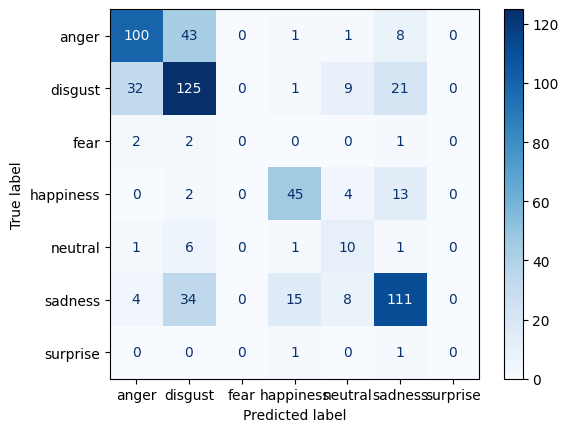

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Calcular e exibir o relatório de classificação
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)

# Gerar e exibir a matriz de confusão
cm = confusion_matrix(y_true, y_pred, labels=range(len(label_encoder.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')

# Teste com avalições da Google Play

In [27]:
teste_emocoes = pd.read_csv('teste_tratado.csv')

# Aplicar a função a todos os elementos da coluna 'content'
teste_emocoes['predicted_emotion'] = teste_emocoes['content'].apply(predict_emotion)

# Exibir o DataFrame com a nova coluna de previsões
teste_emocoes[['app', 'sentiment', 'predicted_emotion']]

,app,sentiment,predicted_emotion
0,iFood,disgust,disgust
1,iFood,sadness,anger
2,Nubank,happiness,sadness
3,Brave Mobile,happiness,sadness
4,Figurinhas do Lula - PT,anger,anger
5,Shopee,sadness,sadness
6,Shopee,anger,disgust
7,Shopee,happiness,sadness
8,Shopee,happiness,happiness
